### Тут показано как запускать модель, имея веса

In [1]:
# вписываем сюда пусть к весам
checkpoint = 'chp_fb_3_bad_data_1e6_bs30.tar'

In [2]:
from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )

### Тулы для преобразований данных

In [3]:
import torch
import torchvision.transforms as t
from typing import Any, List, Optional, Union, Tuple

from torch.utils.data import Dataset
import torchvision.transforms as t
from typing import Tuple, List
from torch.utils.data import DataLoader
import numpy as np


def general_transform():
    transforms = t.Compose([ 
                t.ToTensor(),
                t.Normalize(
                    mean = 0.5,
                    std= 0.5
                )])
    return transforms



# тут про прообразования сам инференс

class Upsample:
    def __init__(self, size: Tuple[int, int]):
        
        self._upsampler = torch.nn.Upsample(size=size)
        self.size = self._upsampler.size
        
    def __call__(self, data, label):
        
        return (self._upsampler(data), 
                (self._upsampler(label)).long())


def predict_model(model,
            data: torch.Tensor, 
            binary: bool):
    """
    Predict the segments

    Parameters
    ----------
    model : UNet
        _description_
    data : torch.Tensor
        _description_

    Returns
    -------
    _type_
        segmented result
    """
    predicted_logit = model(data)

    if binary:
        prob = torch.sigmoid(predicted_logit.squeeze(1))
        # predicted = predicted[predicted>0.5]
        predicted = torch.argmax(torch.diff(prob, dim=1), dim=1)

    else:
        prob = torch.softmax(predicted_logit, dim=1)
        predicted = torch.argmax(prob, dim=1)
    return predicted, prob







In [4]:
# создаем объекты классов указанных выше
upsampler = Upsample(
    size=(n_time_sampels, upsampled_size)
    )

### Загрузка модели

In [5]:
import segmentation_models_pytorch as smp

device = 'cpu'

features = [16, 32, 64, 128]
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,              
    classes=2,                    
    decoder_channels =features[::-1],
    encoder_depth=len(features)
)

state = torch.load(checkpoint, map_location=torch.device(device))
model.load_state_dict(state) 




/var/folders/qx/8lfz_yns1qv3pz4b786vy6dc0000gn/T/ipykernel_79433/2359007324.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint, map_location=

<All keys matched successfully>

### Инференс с нуля (тех данных которые мы сами нагенерили и которые принимает train)

In [6]:
from typing import Any, List, Optional, Union, Tuple

def data_normalize_and_limiting(data: np.ndarray) -> np.ndarray:
    """
    Trace based scale a shot

    Parameters
    ----------
    data : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    norma = np.max(np.abs(data), axis=0)
    norma[np.abs(norma) < 1e-9 * np.max(np.abs(norma))] = 1
    data = data / norma * 2
    data[data < -1] = -1
    data[data > 1] = 1
    return data

def shot_to_gray_scale(data: np.ndarray) -> np.ndarray:
    """
    Transform a shot to grayscale image in [0, 255]

    Parameters
    ----------
    data : np.ndarray
        One seismic shot

    Returns
    -------
    np.ndarray
        The shot in gray scale
    """
    nom = data - np.mean(data, axis=0)
    denom = 2 * (np.max(data, axis=0) - np.min(data, axis=0))
    if denom.all() < 0.000001:
        print("denom", denom)
    data = 255 * (nom/ denom + 0.5)
    data[np.isnan(data)] = 0
    return data

def split_seismogram(shot: np.ndarray, split_nt: int, overlap: float) -> List[np.ndarray]:
    """
    Split a seismogram into overlapping segments of specified width.
    
    Parameters
    ----------
    shot : np.ndarray
        Original seismogram data with shape (time_samples, n_traces)
    split_nt : int
        Width of each segment (number of traces)
    overlap : float
        Overlap fraction between segments (0-1)
    
    Returns
    -------
    List[np.ndarray]
        List of overlapping segments
    """
    n_traces = shot.shape[1]
    
    # If the whole seismogram fits in one segment
    if split_nt >= n_traces:
        return [shot]
    
    # Calculate step size
    stride = int(split_nt * (1 - overlap))
    
    # Generate all starting positions
    starts = list(range(0, n_traces - split_nt + 1, stride))
    print(starts)
    
    # Make sure the last segment ends exactly at the boundary if needed
    if starts[-1] + split_nt < n_traces:
        starts.append(n_traces - split_nt)
    
    # Create segments
    segments = [shot[:, start:start + split_nt] for start in starts]
    
    return segments



def starting_points(n_traces: int,
                    split_nt: int,
                    overlap: float)-> List[int]:
    points = [0]
    stride = int(split_nt * (1 - overlap))
    count = 1
    if split_nt >= n_traces:
        return points
    
    while True:
        pt = count * stride
        if pt + split_nt >= n_traces:
            if pt == n_traces:
                break
            points.append(n_traces - split_nt)
            break
        else:
            points.append(pt)
        
        count += 1

    return points

def shot_spliting(shot: np.ndarray,
                  points: list,
                split_nt: int,
                )-> List[np.ndarray]:
    """
    Split a shot to subshots

    Parameters
    ----------
    shot : Union[np.ndarray, List]
        An ndarray if it is test data
        A list if it is train data
    split_nt : int
        Number of traces in splitted version
    overlap : float
        Overlap between subshots

    Returns
    -------
    List of subshots
        
    """
    data_shot = [shot[:, t:t+split_nt] for t in points]

    return data_shot


In [7]:
import os
os.listdir("data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/")[:20]

['24985217187.npy',
 '24965224193.npy',
 '24936085111.npy',
 '24995236247.npy',
 '24995236253.npy',
 '24965349343.npy',
 '24965224187.npy',
 '24936085105.npy',
 '24985217193.npy',
 '24955226205.npy',
 '24985236175.npy',
 '24986093021.npy',
 '24986105057.npy',
 '24995245295.npy',
 '24936109117.npy',
 '24955226211.npy',
 '24985218277.npy',
 '24995230193.npy',
 '24985219169.npy',
 '24946108087.npy']

#### Из созданного нами файла создаем шоты (по аналогии с фукнцией save_shots_fb из примера)

In [70]:
#file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/9744512.npy' 249452275193
file_path = 'data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/24936095159.npy'

shot = np.load(file_path)
time_window =[0, n_time_sampels]

shot = shot[time_window[0]:time_window[1], :]
shot = data_normalize_and_limiting(data=shot)
shot = shot_to_gray_scale(shot)

points = starting_points(shot.shape[1], split_nt, overlap)
sub_shots = shot_spliting(
    shot=shot,
    points=points,
    split_nt=split_nt
    )
len(sub_shots)

14

#### Берем данные, берем одну фотку и строим картинку

In [71]:
%matplotlib inline

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch


#data_path = 'data/preprocessed/dataset1/test/10753423_0.npy' 
#data_path = 'data/exp_data/97445_1003.npy' 
#shot = [np.load(data_path, allow_pickle=True)]
shot = sub_shots

bs = len(shot)
nt, n_trace = shot[0].shape
batch = torch.zeros((bs, 1, nt, n_trace))
print(batch.shape)
    
# print(shot[0])
for i in range(bs):
   batch[i, 0, ...] = general_transform()(shot[i])

    
# print(batch)
print(batch.shape)
batch, _ = upsampler(batch, batch)

    

torch.Size([14, 1, 512, 64])
torch.Size([14, 1, 512, 64])


In [73]:
predicted, prob = predict_model( # Check why I use prob here but not for validation
    model=model, data=batch,
    binary=False)

downsample = torch.nn.Upsample(size=(n_time_sampels, split_nt))

prob1 = downsample(prob)
predicted = torch.argmax(prob1, dim=1)


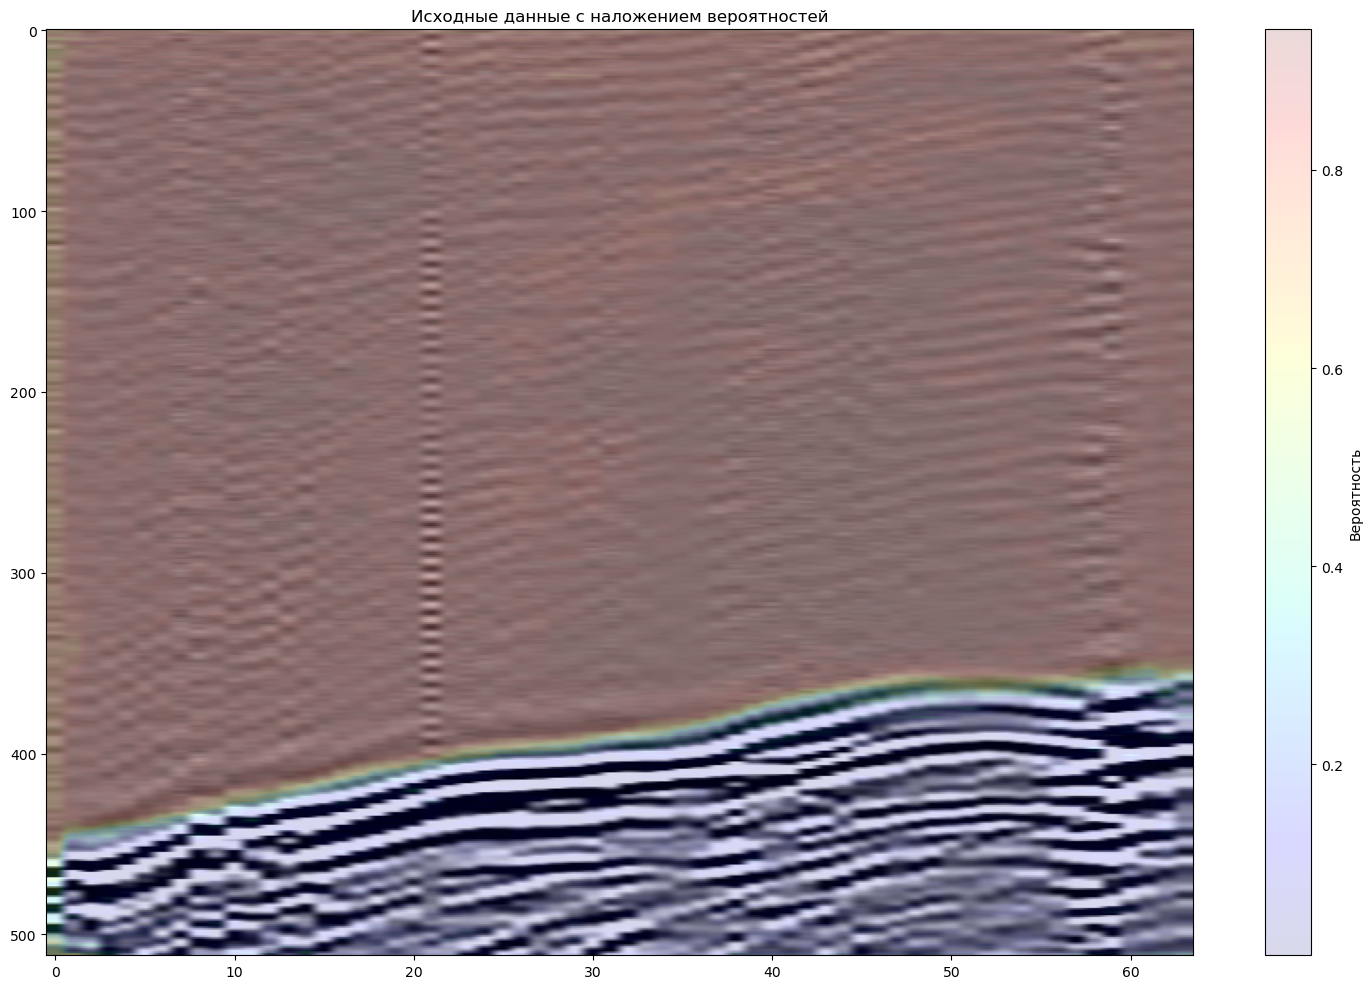

In [74]:


# Extract the probability and original data
i = 2
prob_data = prob1[i][0].detach().numpy().astype(np.float32)
original_data = shot[i]

# Создаем рисунок и оси
fig, ax = plt.subplots(figsize=(15, 10))

# Сначала отображаем исходные данные в оттенках серого
im1 = ax.imshow(original_data, cmap='gray', aspect='auto', origin='upper')

# Затем накладываем данные вероятностей с повышенной прозрачностью
im2 = ax.imshow(prob_data, cmap='jet', alpha=0.15, aspect='auto', origin='upper')  # Уменьшил alpha с 0.5 до 0.3

# Добавляем цветовую шкалу для наложения вероятностей
cbar = plt.colorbar(im2, ax=ax, label='Вероятность')

plt.title('Исходные данные с наложением вероятностей')
plt.tight_layout()
plt.show()

In [75]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def filter_small_clusters(red_probabilities, threshold=0.5):
    """Оставляет только самый большой кластер"""
    binary_mask = (red_probabilities > threshold).astype(np.uint8)
    if np.sum(binary_mask) == 0:
        return red_probabilities
    
    labeled_array, num_features = ndimage.label(binary_mask)
    if num_features <= 1:
        return red_probabilities
    
    sizes = np.bincount(labeled_array.flatten())
    largest_cluster = np.argmax(sizes[1:]) + 1
    largest_mask = (labeled_array == largest_cluster)
    
    filtered_probabilities = np.copy(red_probabilities)
    filtered_probabilities[binary_mask & (~largest_mask)] = 0.0
    
    return filtered_probabilities

def find_class_boundaries(probabilities, threshold=0.5):
    """Находит границу для каждой вертикали"""
    height, width = probabilities.shape
    boundaries = []
    
    for col in range(width):
        column_data = probabilities[:, col]
        binary_column = (column_data > threshold).astype(int)
        transitions = np.diff(binary_column)
        transition_indices = np.where(transitions != 0)[0]
        
        if len(transition_indices) == 0:
            boundaries.append(None)
        else:
            # Берем индекс последнего перехода
            boundaries.append(transition_indices[-1] + 1)
    
    return boundaries

def simple_merge_boundaries(prob1, shot, points, split_nt, threshold=0.5):
    """
    Простое объединение границ
    
    Параметры:
    - prob1: тензор вероятностей для подизображений
    - shot: список подизображений
    - points: стартовые позиции подизображений
    - split_nt: ширина подизображения
    - threshold: порог для бинаризации
    
    Возвращает:
    - объединенную границу для всего изображения
    """
    # Определяем полную ширину изображения
    total_width = points[-1] + split_nt
    
    # Создаем массив для сбора всех значений границ
    # Для каждой вертикали будем хранить список значений
    all_boundaries = [[] for _ in range(total_width)]
    
    # Обрабатываем каждое подизображение
    for i, start_point in enumerate(points):
        # Получаем вероятности для этого подизображения
        prob_data = prob1[i][0].detach().numpy().astype(np.float32)
        
        # Фильтруем малые кластеры
        filtered_prob = filter_small_clusters(prob_data, threshold)
        
        # Находим границу
        boundaries = find_class_boundaries(filtered_prob, threshold)
        
        # Добавляем значения границ в общий список
        for j, boundary in enumerate(boundaries):
            if boundary is not None:
                pos = start_point + j
                if pos < total_width:
                    all_boundaries[pos].append(boundary)
    
    # Выбираем итоговую границу как медиану значений в каждой вертикали
    merged_boundary = []
    for values in all_boundaries:
        if values:
            # Если есть значения, берем медиану
            merged_boundary.append(int(np.median(values)))
        else:
            # Если значений нет, ставим None
            merged_boundary.append(None)
    
    # Заполняем пропуски интерполяцией между соседними значениями
    for i in range(len(merged_boundary)):
        if merged_boundary[i] is None:
            # Находим ближайшие не-None значения слева и справа
            left_val, right_val = None, None
            left_idx, right_idx = i, i
            
            # Ищем слева
            while left_idx > 0:
                left_idx -= 1
                if merged_boundary[left_idx] is not None:
                    left_val = merged_boundary[left_idx]
                    break
            
            # Ищем справа
            while right_idx < len(merged_boundary) - 1:
                right_idx += 1
                if merged_boundary[right_idx] is not None:
                    right_val = merged_boundary[right_idx]
                    break
            
            # Заполняем значение интерполяцией
            if left_val is not None and right_val is not None:
                # Линейная интерполяция
                merged_boundary[i] = left_val + (right_val - left_val) * (i - left_idx) // (right_idx - left_idx)
            elif left_val is not None:
                merged_boundary[i] = left_val
            elif right_val is not None:
                merged_boundary[i] = right_val
            else:
                # Если нигде нет значений, ставим 0
                merged_boundary[i] = 0
    
    return merged_boundary



def smooth_boundary(boundary, sigma=2.0):
    """
    Сглаживает границу с помощью фильтра Гаусса
    
    Параметры:
    - boundary: список или массив значений границы
    - sigma: параметр размытия для фильтра Гаусса (чем больше, тем сильнее сглаживание)
    
    Возвращает:
    - сглаженную границу
    """
    # Преобразуем список в numpy массив
    boundary_array = np.array(boundary)
    
    # Применяем гауссовское сглаживание
    smoothed_boundary = ndimage.gaussian_filter1d(boundary_array, sigma=sigma)
    
    return smoothed_boundary

def visualize_simple_merged_boundary(shot, points, split_nt, merged_boundary):
    """Визуализирует объединенную границу на полном изображении"""
    # Реконструируем полное изображение
    total_width = points[-1] + split_nt
    height = shot[0].shape[0]
    full_image = np.zeros((height, total_width))
    
    for i, start_point in enumerate(points):
        end_point = min(start_point + split_nt, total_width)
        full_image[:, start_point:end_point] = shot[i][:, :end_point-start_point]
    
    # Создаем визуализацию
    plt.figure(figsize=(15, 10))
    plt.imshow(full_image, cmap='gray', aspect='auto', origin='upper')
    
    # Добавляем линию границы
    plt.plot(np.arange(total_width), merged_boundary, 'r-', linewidth=2, label='Граница')
    
    # Показываем границы подизображений
    for point in points:
        plt.axvline(x=point, color='b', linestyle='--', alpha=0.5)
    
    plt.legend()
    plt.title('Полное изображение с объединенной границей')
    plt.tight_layout()
    plt.show()



### threshold=0.85 - важнейший параметр (можно менять)

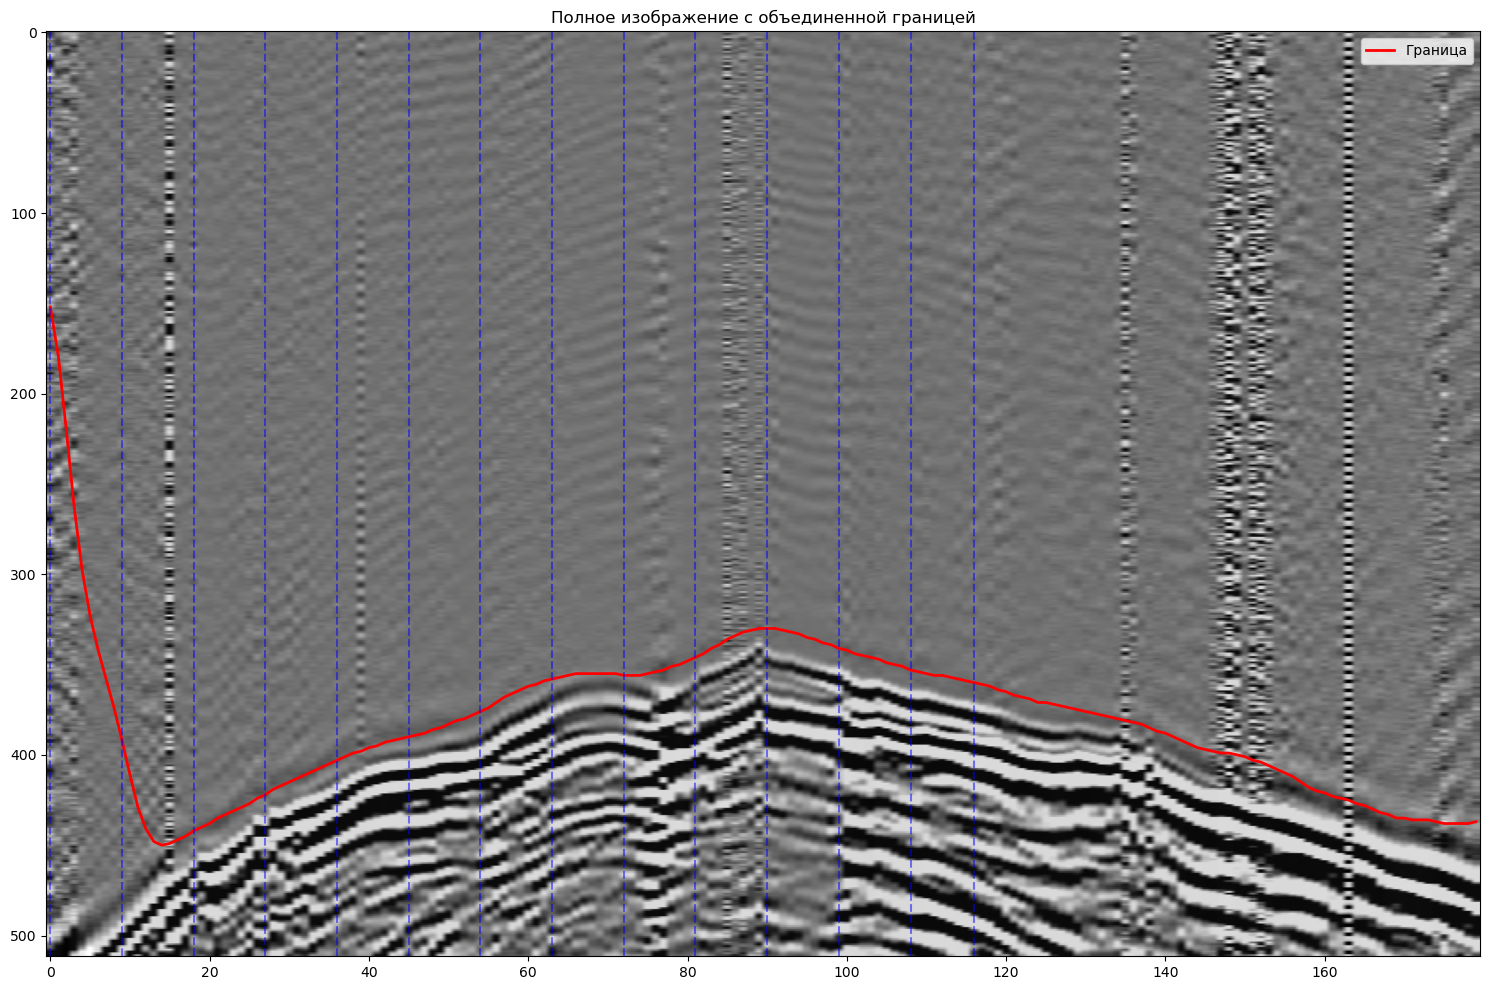

In [76]:
# После обработки изображений и получения predictions
merged_boundary = simple_merge_boundaries(
    prob1=prob1,
    shot=shot,
    points=points,
    split_nt=split_nt,
    threshold=0.85
)

# Сглаживаем границу
smoothed_boundary = smooth_boundary(merged_boundary, sigma=2.0)

# Визуализация результата
visualize_simple_merged_boundary(
    shot=shot,
    points=points,
    split_nt=split_nt,
    merged_boundary=smoothed_boundary
)